# Sugarcane Time-Since-Harvest Tool

In [19]:
# Import required modules and load tile geometries

import sys
import os
import glob
import ipywidgets as widgets

#from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
%matplotlib notebook

from PIL import Image

# Suppress ugly warning from s2cloudless
#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)

# Make sure local modules can be imported
module_path_root = os.path.abspath(os.path.join(os.pardir, os.pardir))
module_path = os.path.join(module_path_root, "Satellite")
if module_path not in sys.path:
    sys.path.append(module_path)

# Import local modules
import Contrib.addressGeocode as geocode
import sentinel.farm          as farm
import sentinel.geometry_list as geometry_list
from sentinel.tilesnapshot import tilesnapshot

# Set current directory to where "data" is, if not done already
try:
    data_path
except NameError:
    import configparser
    config = configparser.ConfigParser()
    config.read('jupyter_satellites.config')
    data_path = config.get('Jupyter_Notebooks', 'data_path')
    os.chdir(data_path)
    
# Load tile geometry data
gl = geometry_list("geometries")

# Function to handle submission of address
def handle_geocode_submit(sender):
    global f
    f = farm.farm(address.value, gl)
    
    if (f.tile_x != 'N/A'):
        # Date picker
        global datepick
        datepick = widgets.Dropdown(
            options     = f.dates,
            value       = max(f.dates),
            description = 'Snapshot Date:',
            disabled    = False
        )
        
        datepick.observe(handle_date_submit)   
        display(datepick)
        
        global g_dateStr
        g_dateStr = max(f.dates)
        
        # Number of days since last havest
        global days_threshold
        days_threshold = widgets.IntSlider(
            min         = 0,
            max         = 750,
            value       = 365,
            description = 'Days since last harvest:',
            disabled    = False
        )
        
        global days_threshold_int
        days_threshold_int = 365
        
        days_threshold.observe(handle_threshold_submit)
        #display(days_threshold)
        
        refresh_button = widgets.Button(
            description  = "Refresh",
            disabled     = False,
            button_style = "",
            tooltip      = "Refresh"
        )
        
        refresh_button.on_click(update_images)
        #display(refresh_button)
        
        neat_box = widgets.HBox([days_threshold, refresh_button])
        display(neat_box)
        
        # Show the latest images by default
        # Make things global so that we overwrite them if we pick a different date
        global fig
        global axs
        fig, axs = plt.subplots(2, 3, figsize=(15, 15))
        fig.suptitle("Tile: " + f.tile_x + ", " + f.tile_y + " (" + str(f.coords['x']) + ", " + str(f.coords['y']) + ")")
        
        update_images(0)

# Function to handle date change
def handle_date_submit(change):
    if ((change['type'] == 'change') and (change['name'] == 'value')):
        global g_dateStr
        g_dateStr = change['new']
        
        update_images(0)

def threshold_days_since_harvest(tile_x, tile_y, dateStr, threshold, size_x=512, size_y=512):
    # Open the relevant tilesnapshot layers for reading
    ts = tilesnapshot(tile_x, tile_y, dateStr, size_x, size_y)
    ts.loadDaysSinceHarvest()
    
    img_threshold = Image.new('RGB', (size_x, size_y))
    
    count_black = 0
    count_raw   = 0
    count_ripe  = 0
    
    max_value = 0
    for y in range(size_y):
        for x in range(size_x):
            current_value = ts.layers['DaysSinceHarvest'][y,x]
            approx_value = round(current_value * 255 / 65535)
            
            # Under-ripe pixels turn from green to greyscale
            if (current_value == 65535):
                img_threshold.putpixel((y, x), (0, 0, 0))
                count_black += 1
            elif (current_value < (threshold * 90)):
                img_threshold.putpixel((y, x), (approx_value, approx_value, approx_value))
                count_raw += 1
            else:
                img_threshold.putpixel((y, x), (0, approx_value, 0))
                count_ripe += 1

            if ((current_value < 65535) and (current_value > max_value)):
                max_value = current_value
                
    #print("COUNTS black [" + str(count_black) + "] raw [" + str(count_raw) + "] ripe [" + str(count_ripe) + "]")
    #print("MAX [" + str(max_value) + "]")
    #print("THRESHOLD [" + str(threshold * 90) + "]")
    
    return img_threshold

def update_images(b):
    dateStr = g_dateStr
    
    tci_file = os.path.join("sugarcanetiles", f.tile_x + "-" + f.tile_y + "-" + "TCI" + "-" + dateStr + ".png")
    tci_img  = mpimg.imread(tci_file)
        
    nvdi_snap_file = os.path.join("masks", "nvdi_intensity", "mask-x" + f.tile_x + "-y" + f.tile_y + "-" + dateStr + ".png")
    nvdi_snap_img  = mpimg.imread(nvdi_snap_file)
        
    nvdi_sticky_file = os.path.join("masks", "nvdi_intensity_cloudless", "mask-x" + f.tile_x + "-y" + f.tile_y + "-" + dateStr + ".png")
    nvdi_sticky_img  = mpimg.imread(nvdi_sticky_file)
        
    masks_file = os.path.join("masks", "harvested_nvdi_masks", "mask-x" + f.tile_x + "-y" + f.tile_y + "-" + dateStr + ".png")
    masks_img  = mpimg.imread(masks_file)
        
    harvest_file = os.path.join("masks", "harvested", "mask-x" + f.tile_x + "-y" + f.tile_y + "-" + dateStr + ".png")
    harvest_img  = mpimg.imread(harvest_file)
    
    days_file = os.path.join("masks", "days_since_harvest_8bit", "mask-x" + f.tile_x + "-y" + f.tile_y + "-" + dateStr + ".png")
    days_img  = mpimg.imread(days_file)
    
    img_threshold = threshold_days_since_harvest(tile_x=f.tile_x, tile_y=f.tile_y, dateStr=dateStr, threshold=days_threshold_int)
    
    axs[0, 0].clear()
    axs[0, 0].imshow(tci_img)
    axs[0, 0].set_title('TCI')
    axs[0, 1].clear()
    axs[0, 1].imshow(nvdi_snap_img)
    axs[0, 1].set_title('NVDI (this snapshot)')
    axs[0, 2].clear()
    axs[0, 2].imshow(nvdi_sticky_img)
    axs[0, 2].set_title('NVDI (sticky)')
    axs[1, 0].clear()
    axs[1, 0].imshow(masks_img)
    axs[1, 0].set_title('Low Vegetation (masked)')
    axs[1, 1].clear()
    axs[1, 1].imshow(harvest_img)
    axs[1, 1].set_title('Harvested this snapshot')
    axs[1, 2].clear()
    axs[1, 2].imshow(img_threshold)
    axs[1, 2].set_title('Days since harvest (' + str(days_threshold_int) + ')')

    plt.show()
        
# Function to handle change of days-since-last-harvest threshold
def handle_threshold_submit(change):
    global days_threshold_int
    if ((change['type'] == 'change') and (change['name'] == 'value')):
        days_threshold_int = change['new']
        #print("Threshold: [" + str(days_threshold_int) + "]")

Text(value='', description='Address', layout=Layout(width='100%'))

Dropdown(description='Snapshot Date:', index=70, options=('2016-12-22', '2017-01-01', '2017-01-11', '2017-02-1…

<IPython.core.display.Javascript object>


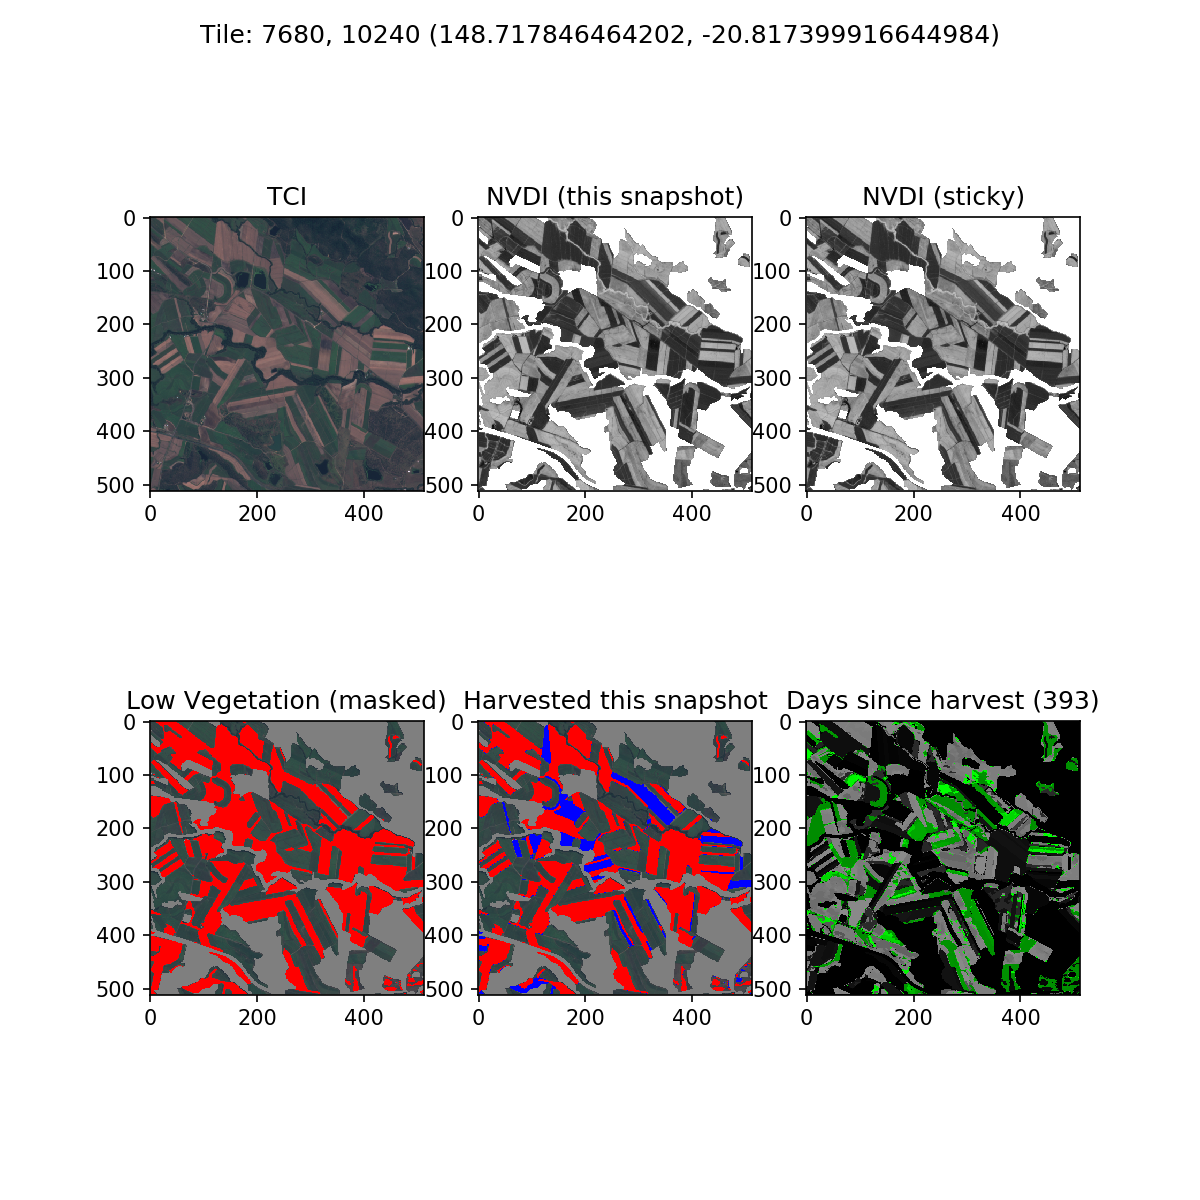

In [20]:
# Prompt for Address (e.g. Dales Rd, 4741)

# Display text box for address entry
address=widgets.Text(
    description='Address',
    layout=widgets.Layout(width='100%')
)

address.on_submit(handle_geocode_submit)
display(address)

# Dales Rd, 4741